# Tutorial 2: Natural Hazard Risk Assessment

In the second tutorial of this week, we are going to use publicly available hazard data and exposure data to do a risk assessment for an area of choice within Europe. More specifically we will look at damage due to wind storms and flooding. 

We will use both Copernicus Land Cover data and OpenStreetMap to estimate the potential damage of natural hazards to the built environment. We will use Copernicus Land Cover data to estimate the damage to specific land-uses, whereas we will use OpenStreetMap to assess the potential damage to the road system.

## Learning Objectives
<hr>

- To know how to download data from the Copernicus Climate Data Store using the `cdsapi` and access it through Python.
- To be able to open and visualize this hazard data.
- To know how to access and open information from the Copernicus Land Monitoring System. Specifically the Corine Land Cover data.
- To understand the basic approach of a natural hazard risk assessment.
- To be able to use the `DamageScanner` to do a damage assessment.
- To interpret and visualize the damage estimates.

<h2>Tutorial Outline<span class="tocSkip"></span></h2>
<hr>
<div class="toc"><ul class="toc-item">
<li><span><a href="#1.-Introducing the packages" data-toc-modified-id="1.-Introducing-the-packages-2">1. Introducing the packages</a></span></li>
<li><span><a href="#2.-Downloading and accessing natural hazard data" data-toc-modified-id="2.-Extracting-hazard-data-3">2. Downloading and accessing natural hazard data</a></span></li>
<li><span><a href="#3.-Explore the natural hazard data" data-toc-modified-id="3.-Explore-hazard-data-4">3. Explore the natural hazard data</a></span></li>
<li><span><a href="#4.-Downloading and accessing Corine Land Cover" data-toc-modified-id="4.-Extracting-CLC-data-3">4. Downloading and accessing Corine Land Cover</a></span></li>    
<li><span><a href="#5.-Perform a damage assessment using Coring Land Cover" data-toc-modified-id="5.-Damage-CLC-5">5. Perform a damage assessment using Coring Land Cover</a></span></li>
<li><span><a href="#5.-Perform a damage assessment using OpenStreetMap" data-toc-modified-id="5.-Damage-OSM-5">6. Perform a damage assessment using OpenStreetMap</a></span></li>    
<li><span><a href="#7.-Interpret and visualize your damage estimates" data-toc-modified-id="5.-Analyze-buildings-6">7. Interpret and visualize your damage estimates</a></span></li></ul></div>

## 1.Introducing the packages
<hr>

Within this tutorial, we are going to make use of the following packages: 

[**GeoPandas**](https://geopandas.org/) is a Python packagee that extends the datatypes used by pandas to allow spatial operations on geometric types.

[**OSMnx**](https://osmnx.readthedocs.io/) is a Python package that lets you download geospatial data from OpenStreetMap and model, project, visualize, and analyze real-world street networks and any other geospatial geometries. You can download and model walkable, drivable, or bikeable urban networks with a single line of Python code then easily analyze and visualize them. You can just as easily download and work with other infrastructure types, amenities/points of interest, building footprints, elevation data, street bearings/orientations, and speed/travel time.

[**xarray**](https://docs.xarray.dev/) is a Python package that allows for easy and efficient use of multi-dimensional arrays.

[**Matplotlib**](https://matplotlib.org/) is a comprehensive Python package for creating static, animated, and interactive visualizations in Python. Matplotlib makes easy things easy and hard things possible.

*We will first need to install the missing packages in the cell below. Uncomment them to make sure we can pip install them*

In [ ]:
#!pip install osmnx
#!pip install geopandas
#!pip install contextily

And we will import these packages in the cell below:

In [1]:
import os
import numpy as np
import rasterio
import cdsapi
import xarray as xr
import pygeos 
import geopandas as gpd
import osmnx as ox
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

from zipfile import ZipFile
from matplotlib import rcParams, cycler
import matplotlib

import urllib3
urllib3.disable_warnings()

## 2. Downloading and accessing natural hazard data
<hr>

We are going to perform a damage assessment using both windstorm data and flood data for Europe.

### Windstorm Data

The windstorm data will be downloaded from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/). As we have seen during the lecture, and as you can also see by browsing on this website, there is an awful lot of climate data available through this Data Store. As such, it is very valuable to understand how to access and download this information to use within an analysis. To keep things simple, we only download one dataset today: [A winter windstorm](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-european-wind-storm-indicators?tab=overview). 

We will do so using an **API**, which is the acronym for application programming interface. It is a software intermediary that allows two applications to talk to each other. APIs are an accessible way to extract and share data within and across organizations. APIs are all around us. Every time you use a rideshare app, send a mobile payment, or change the thermostat temperature from your phone, you’re using an API.

However, before we can access this **API**, we need to take a few steps. Most importantly, we need to register ourselves on the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/) portal. To do so, we need to register, as explained in the video clip below:

<img src="../_static/images/CDS_registration.gif" class="bg-primary mb-1">
<br>

Now, the next step is to access the API. You can now login on the website of the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/). After you login, you can click on your name in the top right corner of the webpage (next to the login button). On the personal page that has just opened, you will find your user ID (**uid**) and your personal **API**. You need to add those in the cell below to be able to download the windstorm.

As you can see in the cell below, we download a specific windstorm that has occured on the seventh of February in 2020. This is storm [Ciara](https://en.wikipedia.org/wiki/Storm_Ciara). 

In [2]:
uid = 76974
apikey = 'ace04e3e-84e3-4d0c-ae9d-d248aca1f5e5'

c = cdsapi.Client(key=f"{uid}:{apikey}", url="https://cds.climate.copernicus.eu/api/v2")

c.retrieve(
    'sis-european-wind-storm-indicators',
    {
        'variable': 'all',
        'format': 'zip',
        'product': 'windstorm_footprints',
        'year': '2020',
        'month': '02',
        'day': '07',
    },
    'Ciara.zip')

2022-12-16 09:38:12,340 INFO Welcome to the CDS
2022-12-16 09:38:12,343 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/sis-european-wind-storm-indicators
2022-12-16 09:38:12,615 INFO Request is completed
2022-12-16 09:38:12,617 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data0/dataset-sis-european-wind-storm-indicators-6953466e-04b2-446f-aa78-f21da4ed7d17.zip to Ciara.zip (14.2M)
2022-12-16 09:38:14,247 INFO Download rate 8.7M/s                                                                      


Result(content_length=14862375,content_type=application/zip,location=https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data0/dataset-sis-european-wind-storm-indicators-6953466e-04b2-446f-aa78-f21da4ed7d17.zip)

### Flood Data

The flood data we will extract from a repository maintained by the European Commission Joint Research Centre. We will download river flood hazard maps from their [Flood Data Collection](https://data.jrc.ec.europa.eu/collection/id-0054). 

Here we do not need to use an API and we also do not need to register ourselves, so we can download any of the files directly. To do so, we use the `urllib` package.

In [3]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

## this is the link to the 1/100 flood map for Europe
zipurl = 'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/FLOODS/deprecated/Old_EUmaps%20before%20Oct2020/floodMapEU_rp100y.zip'

# and now we open and extract the data
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('C:\Data\Flood_Data')

## 3. Explore the natural hazard data
<hr>

As you can see in the section above, we have downloaded the storm footprint in a zipfile. Let's open the zipfile and load the dataset using the `xarray` package through the `open_dataset()` function.

In [4]:
with ZipFile('Ciara.zip') as zf:
    
    # Let's get the filename first
    file = zf.namelist()[0]
    
    # And now we can open and select the file within Python
    with zf.open(file) as f:
        ds_disk = xr.open_dataset(f)

Let's have a look at the storm we have downloaded!

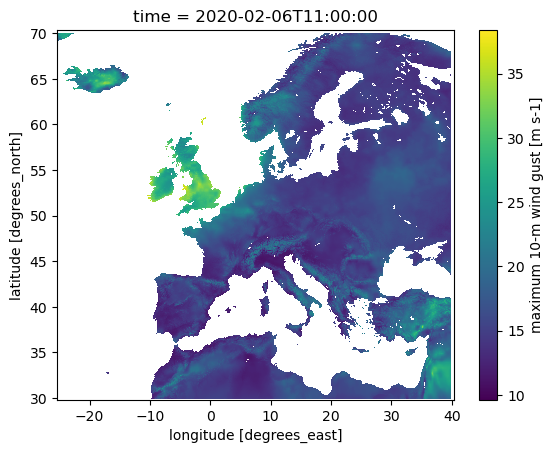

In [5]:
ds_disk['max_wind_gust'].plot()

And similarly, we want to open the flood map. But now we do not have to unzip the file anymore and we can directly open it through using `rasterio`:

In [6]:
flood_map_path = os.path.join('C:\Data\Flood_data','floodMapEU_rp100y.tif')

with rasterio.open(flood_map_path) as src:
    flood_map = src.read()[0, 
                           :, :]
    transform = src.transform

And let's have a look at the flood data as well.

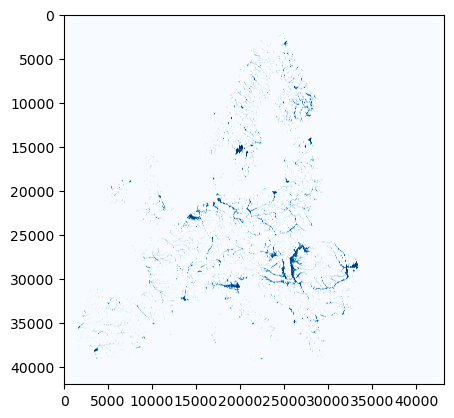

In [87]:
plt.imshow(flood_map,cmap='Blues')

## 4. Download and access Copernicus Land Cover data
<hr>

Unfortunately, there is no API option to download the [Corine Land Cover](https://land.copernicus.eu/pan-european/corine-land-cover) data. We will have to download the data from the website first.

To do so, we will first have to register ourselves again on the website. Please find in the video clip below how to register yourself on the website of the [Copernicus Land Monitoring Service](https://land.copernicus.eu/):

<img src="../_static/images/CLMS_registration.gif" class="bg-primary mb-1">

Now click on the Login button in the top right corner to login on the website. There are many interesting datasets on this website, but we just want to download the Corine Land Cover data, and specifically the latest version: [Corine Land Cover 2018](https://land.copernicus.eu/pan-european/corine-land-cover/clc2018?tab=download). To do so, please select the **Corine Land Cover - 100 meter**. Now click on the large green Download button. Your download should start any minute.

Slightly annoying, the file you have downloaded is double zipped. Its slightly inconvenient to open this through Python and within Google Drive. So let's unzip it twice outside of Python and store the data in a directory named `Data`. 

In [2]:
CLC_location = os.path.join('C:\Data\CLC\DATA','U2018_CLC2018_V2020_20u1.tif')

In [18]:
import rioxarray
place_name = "Gelderland, The Netherlands"
area = ox.geocode_to_gdf(place_name)

In [19]:
xds = xr.open_dataset(CLC_location, engine="rasterio")
xds

<xarray.Dataset>
Dimensions:      (band: 1, x: 65000, y: 46000)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 9e+05 9.002e+05 9.002e+05 ... 7.4e+06 7.4e+06
  * y            (y) float64 5.5e+06 5.5e+06 5.5e+06 ... 9.002e+05 9e+05
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [20]:
clipped = xds.rio.clip(area.geometry.values, area.crs)

In [21]:
CLC_values = [111, 112, 121, 122, 123, 124, 131, 132, 133, 141, 142, 211, 212, 213, 221, 222, 223, 231, 241, 242,
 243, 244, 311, 312, 313, 321, 322, 323, 324, 331, 332, 333, 334, 335, 411, 412, 421, 422, 423, 511, 512, 521, 522, 523]

CLC_colors = ['#E6004D', '#FF0000', '#CC4DF2', '#CC0000', '#E6CCCC', '#E6CCE6', '#A600CC', '#A64DCC', '#FF4DFF', '#FFA6FF', '#FFE6FF', '#FFFFA8', '#FFFF00', '#E6E600',
 '#E68000', '#F2A64D', '#E6A600', '#E6E64D', '#FFE6A6', '#FFE64D', '#E6CC4D', '#F2CCA6', '#80FF00', '#00A600',
 '#4DFF00', '#CCF24D', '#A6FF80', '#A6E64D', '#A6F200', '#E6E6E6', '#CCCCCC', '#CCFFCC', '#000000', '#A6E6CC',
 '#A6A6FF', '#4D4DFF', '#CCCCFF', '#E6E6FF', '#A6A6E6', '#00CCF2', '#80F2E6', '#00FFA6', '#A6FFE6', '#E6F2FF']

In [22]:
color_dict_raster = dict(zip(CLC_values,CLC_colors))

# We create a colormar from our list of colors
cm = ListedColormap(CLC_colors)

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(CLC_values)
len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*color_dict_raster.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

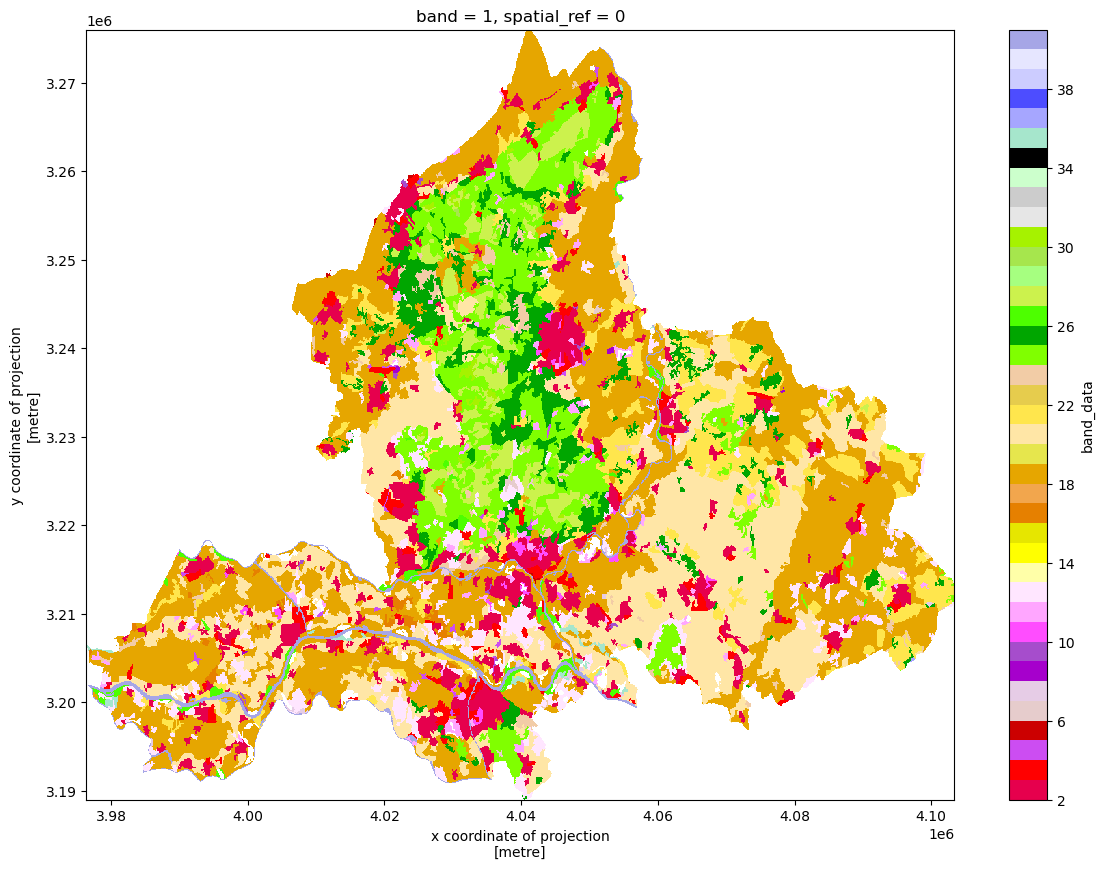

In [23]:
fig, ax = plt.subplots(1, 1,figsize=(14,10))

clipped["band_data"].plot(ax=ax,levels=len(CLC_colors),colors=CLC_colors)

## 5. Perform a damage assessment using Coring Land Cover
<hr>

## 6. Perform a damage assessment of the road network using OpenStreetMap
<hr>

## 7. Interpret and visualize your damage estimates
<hr>